<h1 align=center><font size = 5>Capstone Project</font></h1>

## Introduction

The problem I pretend to solve is very particular but can be extremely important for me. Since I´m moving to Manhattan I need to decide where exactly I should move, considering the next features:
1. I´m mexican, so I want to live somewhere with a lot of Mexican restarants.
2. I enjoy working out, so I must be able to find gyms nearby.
3. I like walking in Parks.
4. I really love Italian Food.
5. I´m interested on doing Yoga.

## Data

To success in my research I will need to extract data regarding Manhattan from the Neighborhoods and Boroughs in New York.
This data can be obtained from this website: https://cocl.us/new_york_dataset, and fro the analysis we´ll require information coming from Foursquare to look for relevant information according to our goals.

## 1. Download and Explore Dataset

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [4]:
import wget
#!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
#wget.download('https://cocl.us/new_york_dataset')
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

In [5]:
with open('new_york_dataset') as json_data:
    newyork_data = json.load(json_data)

#### Tranform the data into a *pandas* dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
neighborhoods_data = newyork_data['features']
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of Manhattan.

In [9]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [10]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


### Neighborhoods in Manhattan

In [11]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

### Explore the neighborhoods and segment them using the Foursquare API

#### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = '20IYEBXH0Z5OKY3I0Z53GSJBOIELTPCETBOPB4GAIHVXUQC0' # your Foursquare ID
CLIENT_SECRET = 'CVKU2IR5IVCPOOFLXATAX15FHTKGR5SFUA4Y5YJHQML10UXZ' # your Foursquare Secret
VERSION = '20201704' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 20IYEBXH0Z5OKY3I0Z53GSJBOIELTPCETBOPB4GAIHVXUQC0
CLIENT_SECRET:CVKU2IR5IVCPOOFLXATAX15FHTKGR5SFUA4Y5YJHQML10UXZ


## 2. Explore Neighborhoods in Manhattan

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [14]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



#### Let's check the size of the resulting dataframe

In [15]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3028, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [16]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy

And let's examine the new dataframe size.

In [17]:
manhattan_onehot.shape

(3028, 322)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [18]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Social Club,Soup Place,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy

#### Let's confirm the new size

In [19]:
manhattan_grouped.shape

(40, 322)

In [20]:
manhattan_P = manhattan_grouped[['Neighborhood','Mexican Restaurant','Gym','Park','Italian Restaurant','Yoga Studio']]
manhattan_P.head()

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
0,Battery Park City,0.016667,0.066667,0.10000,0.033333,0.000000
1,Carnegie Hill,0.011628,0.034884,0.00000,0.034884,0.034884
2,Central Harlem,0.000000,0.023810,0.02381,0.000000,0.000000
3,Chelsea,0.000000,0.010000,0.02000,0.030000,0.000000
4,Chinatown,0.020000,0.000000,0.00000,0.000000,0.010000


## 4. Cluster Neighborhoods

In [21]:
# set number of clusters
kclusters = 5

manhattan_grouped_clustering = manhattan_P.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

### Including Cluster Labels to Top Ten Data Frame

In [27]:
# add clustering labels
manhattan_P.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(manhattan_P.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
0,Manhattan,Marble Hill,40.876551,-73.910660,2,0.000000,0.080000,0.000000,0.000000,0.040000
1,Manhattan,Chinatown,40.715618,-73.994279,1,0.020000,0.000000,0.000000,0.000000,0.010000
2,Manhattan,Washington Heights,40.851903,-73.936900,1,0.022222,0.022222,0.022222,0.011111,0.000000
3,Manhattan,Inwood,40.867684,-73.921210,4,0.070175,0.000000,0.035088,0.000000,0.017544
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,0.050847,0.000000,0.016949,0.016949,0.033898


### Map with Clusters

In [71]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [72]:
manhattan_clusters = manhattan_merged[['Neighborhood','Cluster Labels','Mexican Restaurant','Gym','Park','Italian Restaurant','Yoga Studio']]
manhattan_clusters

,Neighborhood,Cluster Labels,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
0,Marble Hill,2,0.000000,0.080000,0.000000,0.000000,0.040000
1,Chinatown,1,0.020000,0.000000,0.000000,0.000000,0.010000
2,Washington Heights,1,0.022222,0.022222,0.022222,0.011111,0.000000
3,Inwood,4,0.070175,0.000000,0.035088,0.000000,0.017544
4,Hamilton Heights,4,0.050847,0.000000,0.016949,0.016949,0.033898
5,Manhattanville,4,0.043478,0.000000,0.043478,0.043478,0.000000
6,Central Harlem,1,0.000000,0.023810,0.023810,0.000000,0.000000
7,East Harlem,4,0.119048,0.023810,0.023810,0.000000,0.000000
8,Upper East Side,0,0.011111,0.000000,0.011111,0.088889,0.033333
9,Yorkville,0,0.030000,0.060000,0.020000,0.080000,0.000000


In [73]:
Perf = pd.DataFrame({'Neighborhood':['Perf'],'Cluster Labels':'Nan','Mexican Restaurant':1.0,'Gym':1.0,'Park':1.0,'Italian Restaurant':1.0,'Yoga Studio':1.0})
Perf

,Neighborhood,Cluster Labels,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
0,Perf,Nan,1.0,1.0,1.0,1.0,1.0


In [74]:
from sklearn import preprocessing

X = manhattan_clusters[['Mexican Restaurant','Gym','Park','Italian Restaurant','Yoga Studio']].values  #.astype(float)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-0.66646029,  2.87096912, -0.92771837, -1.13009847,  2.11454743],
       [ 0.14129587, -1.01921403, -0.92771837, -1.13009847, -0.08248638],
       [ 0.23104655,  0.0613924 , -0.21568141, -0.76274238, -0.81483099],
       [ 2.16777185, -1.01921403,  0.19655051, -1.13009847,  0.46998411],
       [ 1.38715707, -1.01921403, -0.38463934, -0.56972478,  1.66769309]])

In [75]:
y = manhattan_clusters['Cluster Labels'].values  #.astype(float)
y[0:5]

array([2, 1, 1, 4, 4])

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (32, 5) (32,)
Test set: (8, 5) (8,)


## 5. Classify myself

### Training

In [77]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.875, 0.875, 0.625, 0.75 , 0.625, 0.5  , 0.5  , 0.375, 0.375])

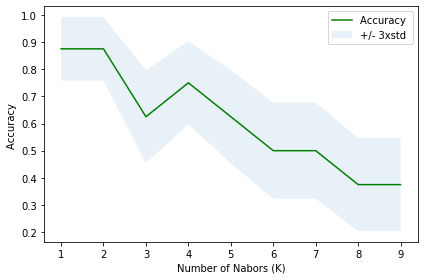

In [78]:
import matplotlib.pyplot as plt

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [79]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.875 with k= 1


In [80]:
k = 1
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Predicting

In [81]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([3, 1, 4, 1, 4])

### Accuracy evaluation

In [82]:
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Test set Accuracy:  0.875


### Know our Cluster

In [83]:
X_P = Perf[['Mexican Restaurant','Gym','Park','Italian Restaurant','Yoga Studio']].values  #.astype(float)
X_P = preprocessing.StandardScaler().fit(X_P).transform(X_P.astype(float))

#### Cluster 0

In [84]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
8,Upper East Side,0.011111,0.000000,0.011111,0.088889,0.033333
9,Yorkville,0.030000,0.060000,0.020000,0.080000,0.000000
10,Lenox Hill,0.010000,0.030000,0.000000,0.070000,0.000000
12,Upper West Side,0.000000,0.014706,0.000000,0.058824,0.000000
18,Greenwich Village,0.000000,0.030000,0.010000,0.110000,0.010000
21,Tribeca,0.000000,0.000000,0.067568,0.067568,0.013514
23,Soho,0.000000,0.027027,0.000000,0.094595,0.013514
24,West Village,0.000000,0.020000,0.040000,0.090000,0.000000
31,Noho,0.010000,0.010000,0.000000,0.060000,0.010000
34,Sutton Place,0.021505,0.021505,0.043011,0.064516,0.021505


#### Cluster 1

In [85]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
1,Chinatown,0.020000,0.000000,0.000000,0.000000,0.010000
2,Washington Heights,0.022222,0.022222,0.022222,0.011111,0.000000
6,Central Harlem,0.000000,0.023810,0.023810,0.000000,0.000000
13,Lincoln Square,0.000000,0.021053,0.010526,0.042105,0.010526
14,Clinton,0.000000,0.040000,0.010000,0.030000,0.000000
15,Midtown,0.000000,0.030000,0.010000,0.010000,0.000000
16,Murray Hill,0.000000,0.011494,0.000000,0.011494,0.011494
17,Chelsea,0.000000,0.010000,0.020000,0.030000,0.000000
19,East Village,0.020000,0.000000,0.010000,0.020000,0.000000
22,Little Italy,0.000000,0.000000,0.000000,0.040000,0.000000


#### Cluster 2

In [86]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
0,Marble Hill,0.000000,0.080000,0.000000,0.000000,0.040000
30,Carnegie Hill,0.011628,0.034884,0.000000,0.034884,0.034884
32,Civic Center,0.000000,0.022989,0.034483,0.011494,0.034483
38,Flatiron,0.000000,0.040000,0.030000,0.030000,0.030000


#### Cluster 3

In [87]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
11,Roosevelt Island,0.000000,0.040000,0.080000,0.000000,0.0
26,Morningside Heights,0.025641,0.000000,0.102564,0.000000,0.0
28,Battery Park City,0.016667,0.066667,0.100000,0.033333,0.0
37,Stuyvesant Town,0.000000,0.066667,0.133333,0.000000,0.0


#### Cluster 4

In [92]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,Mexican Restaurant,Gym,Park,Italian Restaurant,Yoga Studio
3,Inwood,0.070175,0.000000,0.035088,0.000000,0.017544
4,Hamilton Heights,0.050847,0.000000,0.016949,0.016949,0.033898
5,Manhattanville,0.043478,0.000000,0.043478,0.043478,0.000000
7,East Harlem,0.119048,0.023810,0.023810,0.000000,0.000000
20,Lower East Side,0.021277,0.000000,0.042553,0.021277,0.021277
25,Manhattan Valley,0.050000,0.000000,0.025000,0.025000,0.050000
27,Gramercy,0.041667,0.000000,0.027778,0.041667,0.013889
36,Tudor City,0.054795,0.013699,0.068493,0.013699,0.013699


## Our Cluster is:

In [97]:
our_cluster = neigh.predict(X_P)
print("CLUSTER NUMBER ", our_cluster[0])

CLUSTER NUMBER  1


## Map of places where I can easily be happy

In [94]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == 1:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
map_clusters